In [1]:
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

# conversion from l coordinate to lonlat coordinate
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = a - ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

Tokyo
lat 1365
lat 1653
lon 3693
lon 3981 

lat 1497
lat 1521
lon 3825
lon 3849 



/home/kajiyama/downloads/miniconda3/envs/jupyter39/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/kajiyama/downloads/miniconda3/envs/jupyter39/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


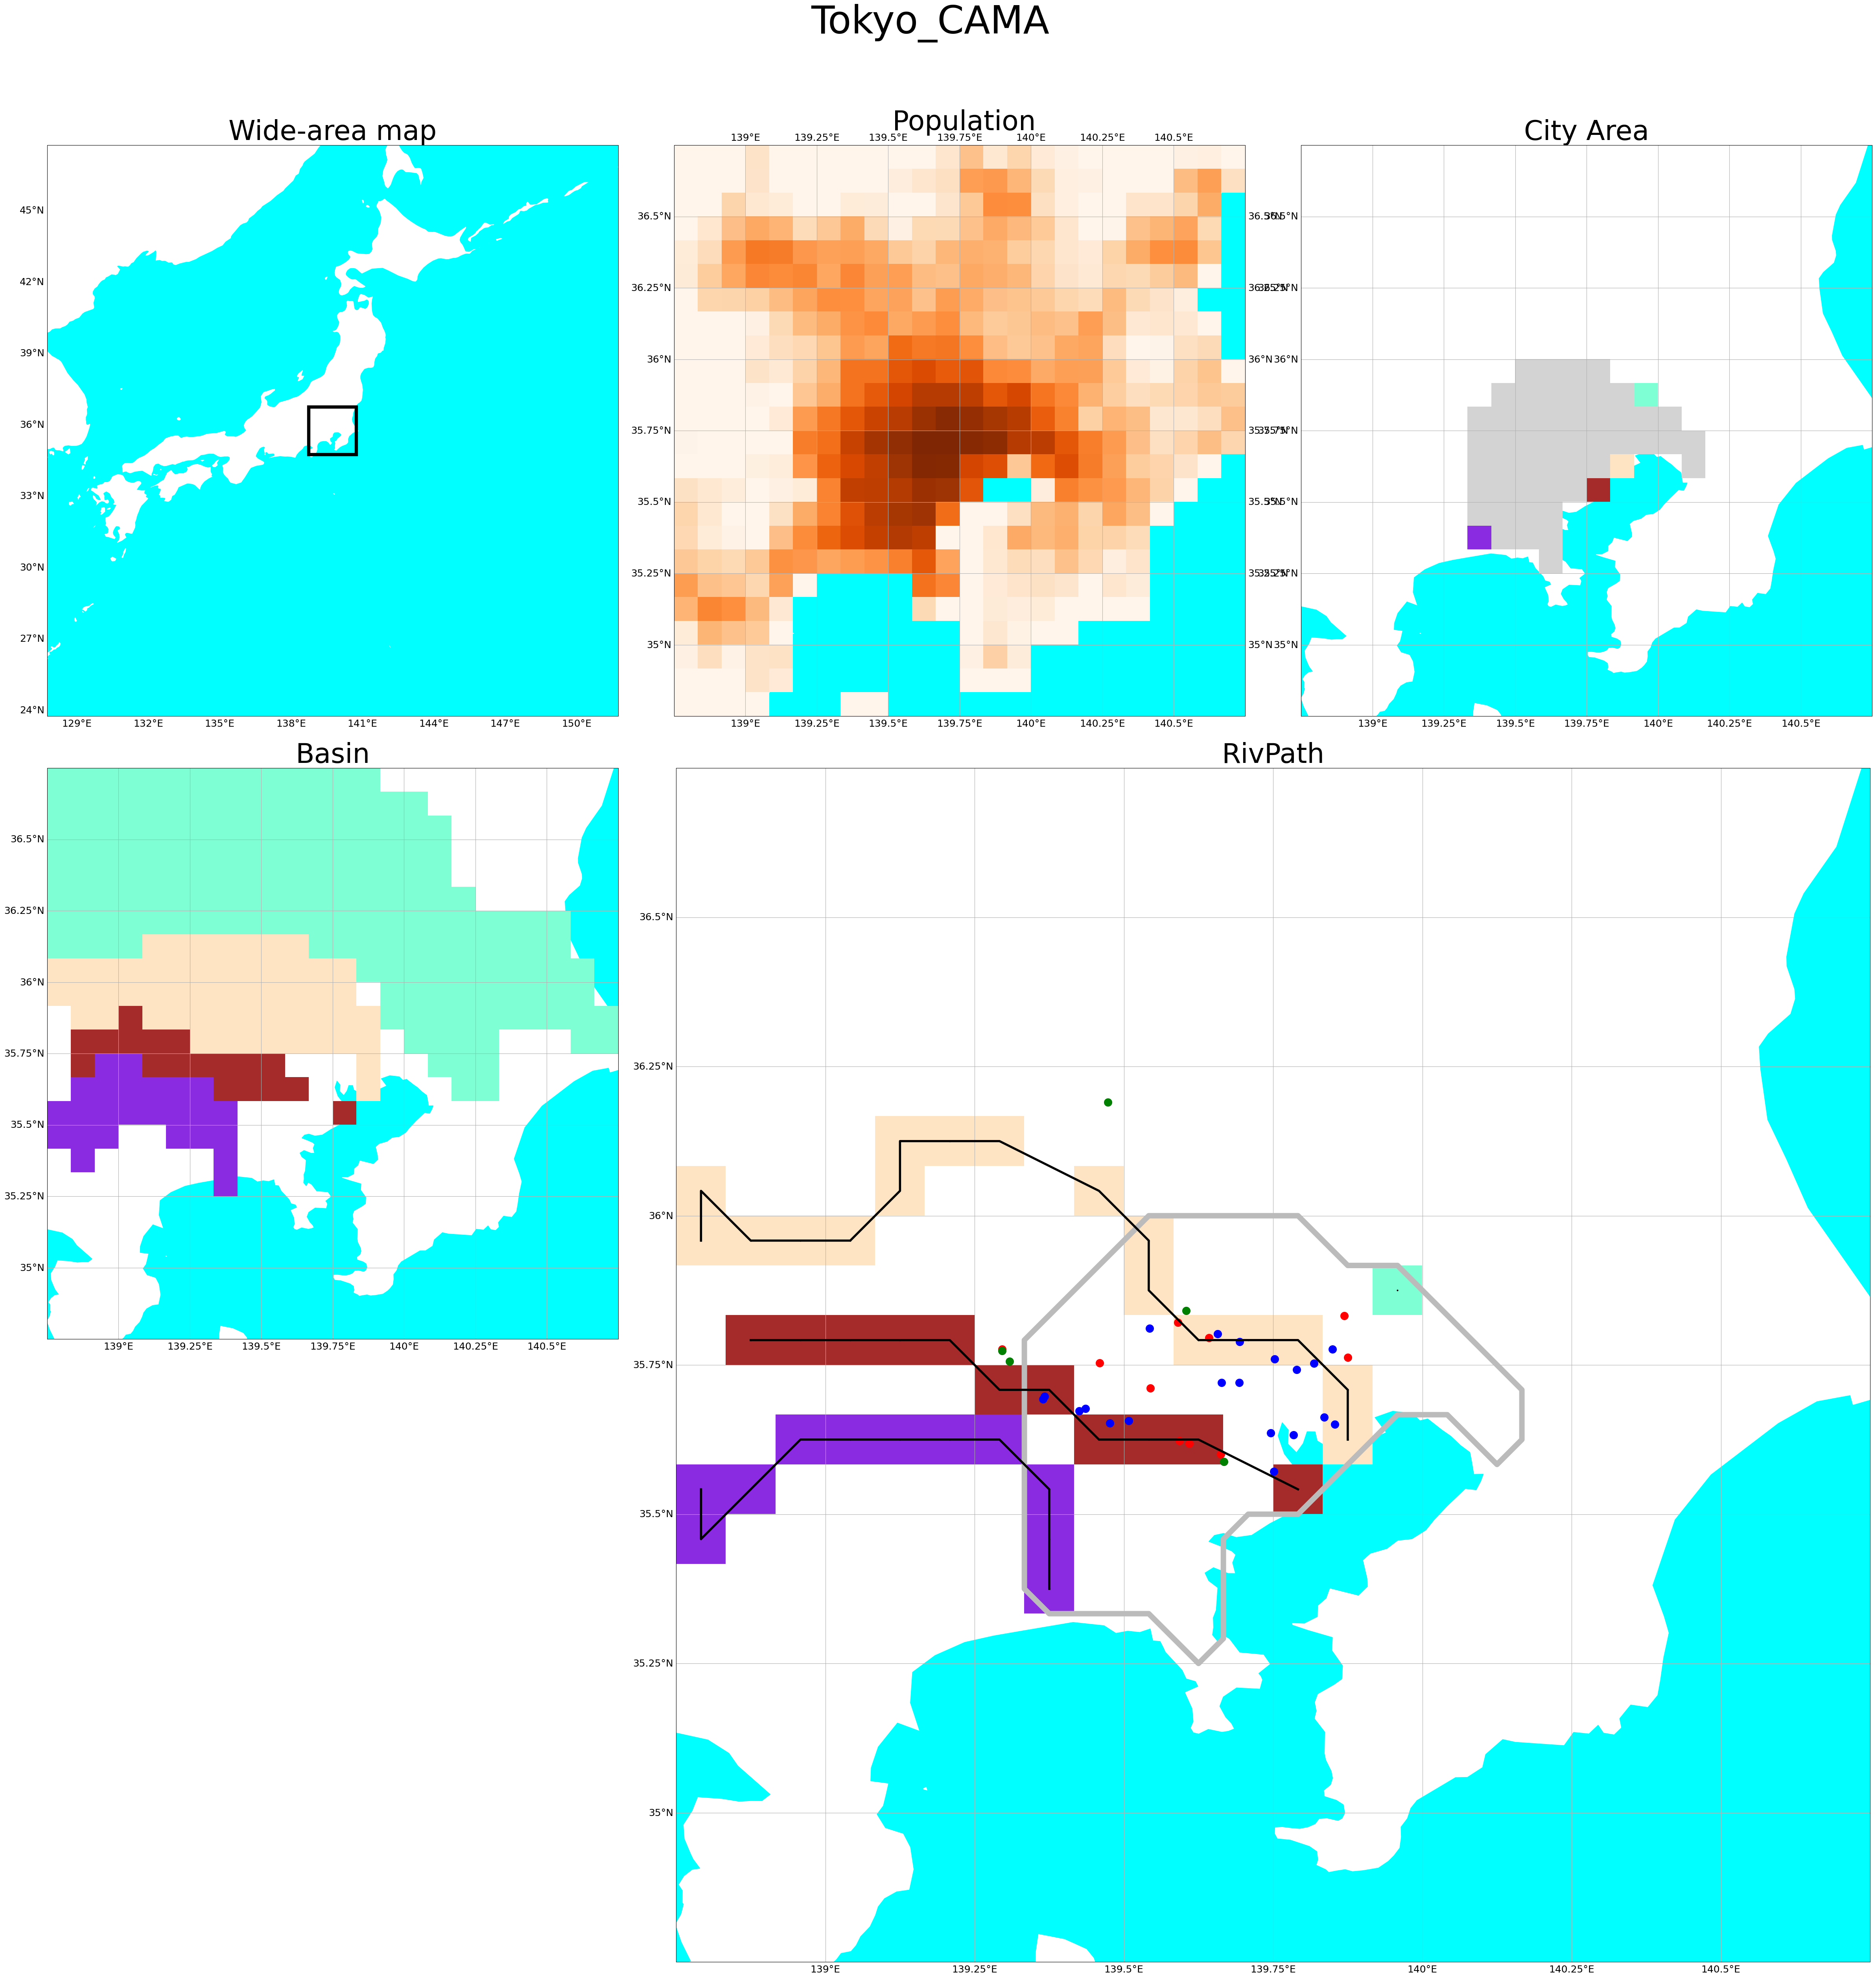

KinkiM.M.A.(Osaka)
lat 1353
lat 1641
lon 3642
lon 3930 

lat 1485
lat 1509
lon 3774
lon 3798 



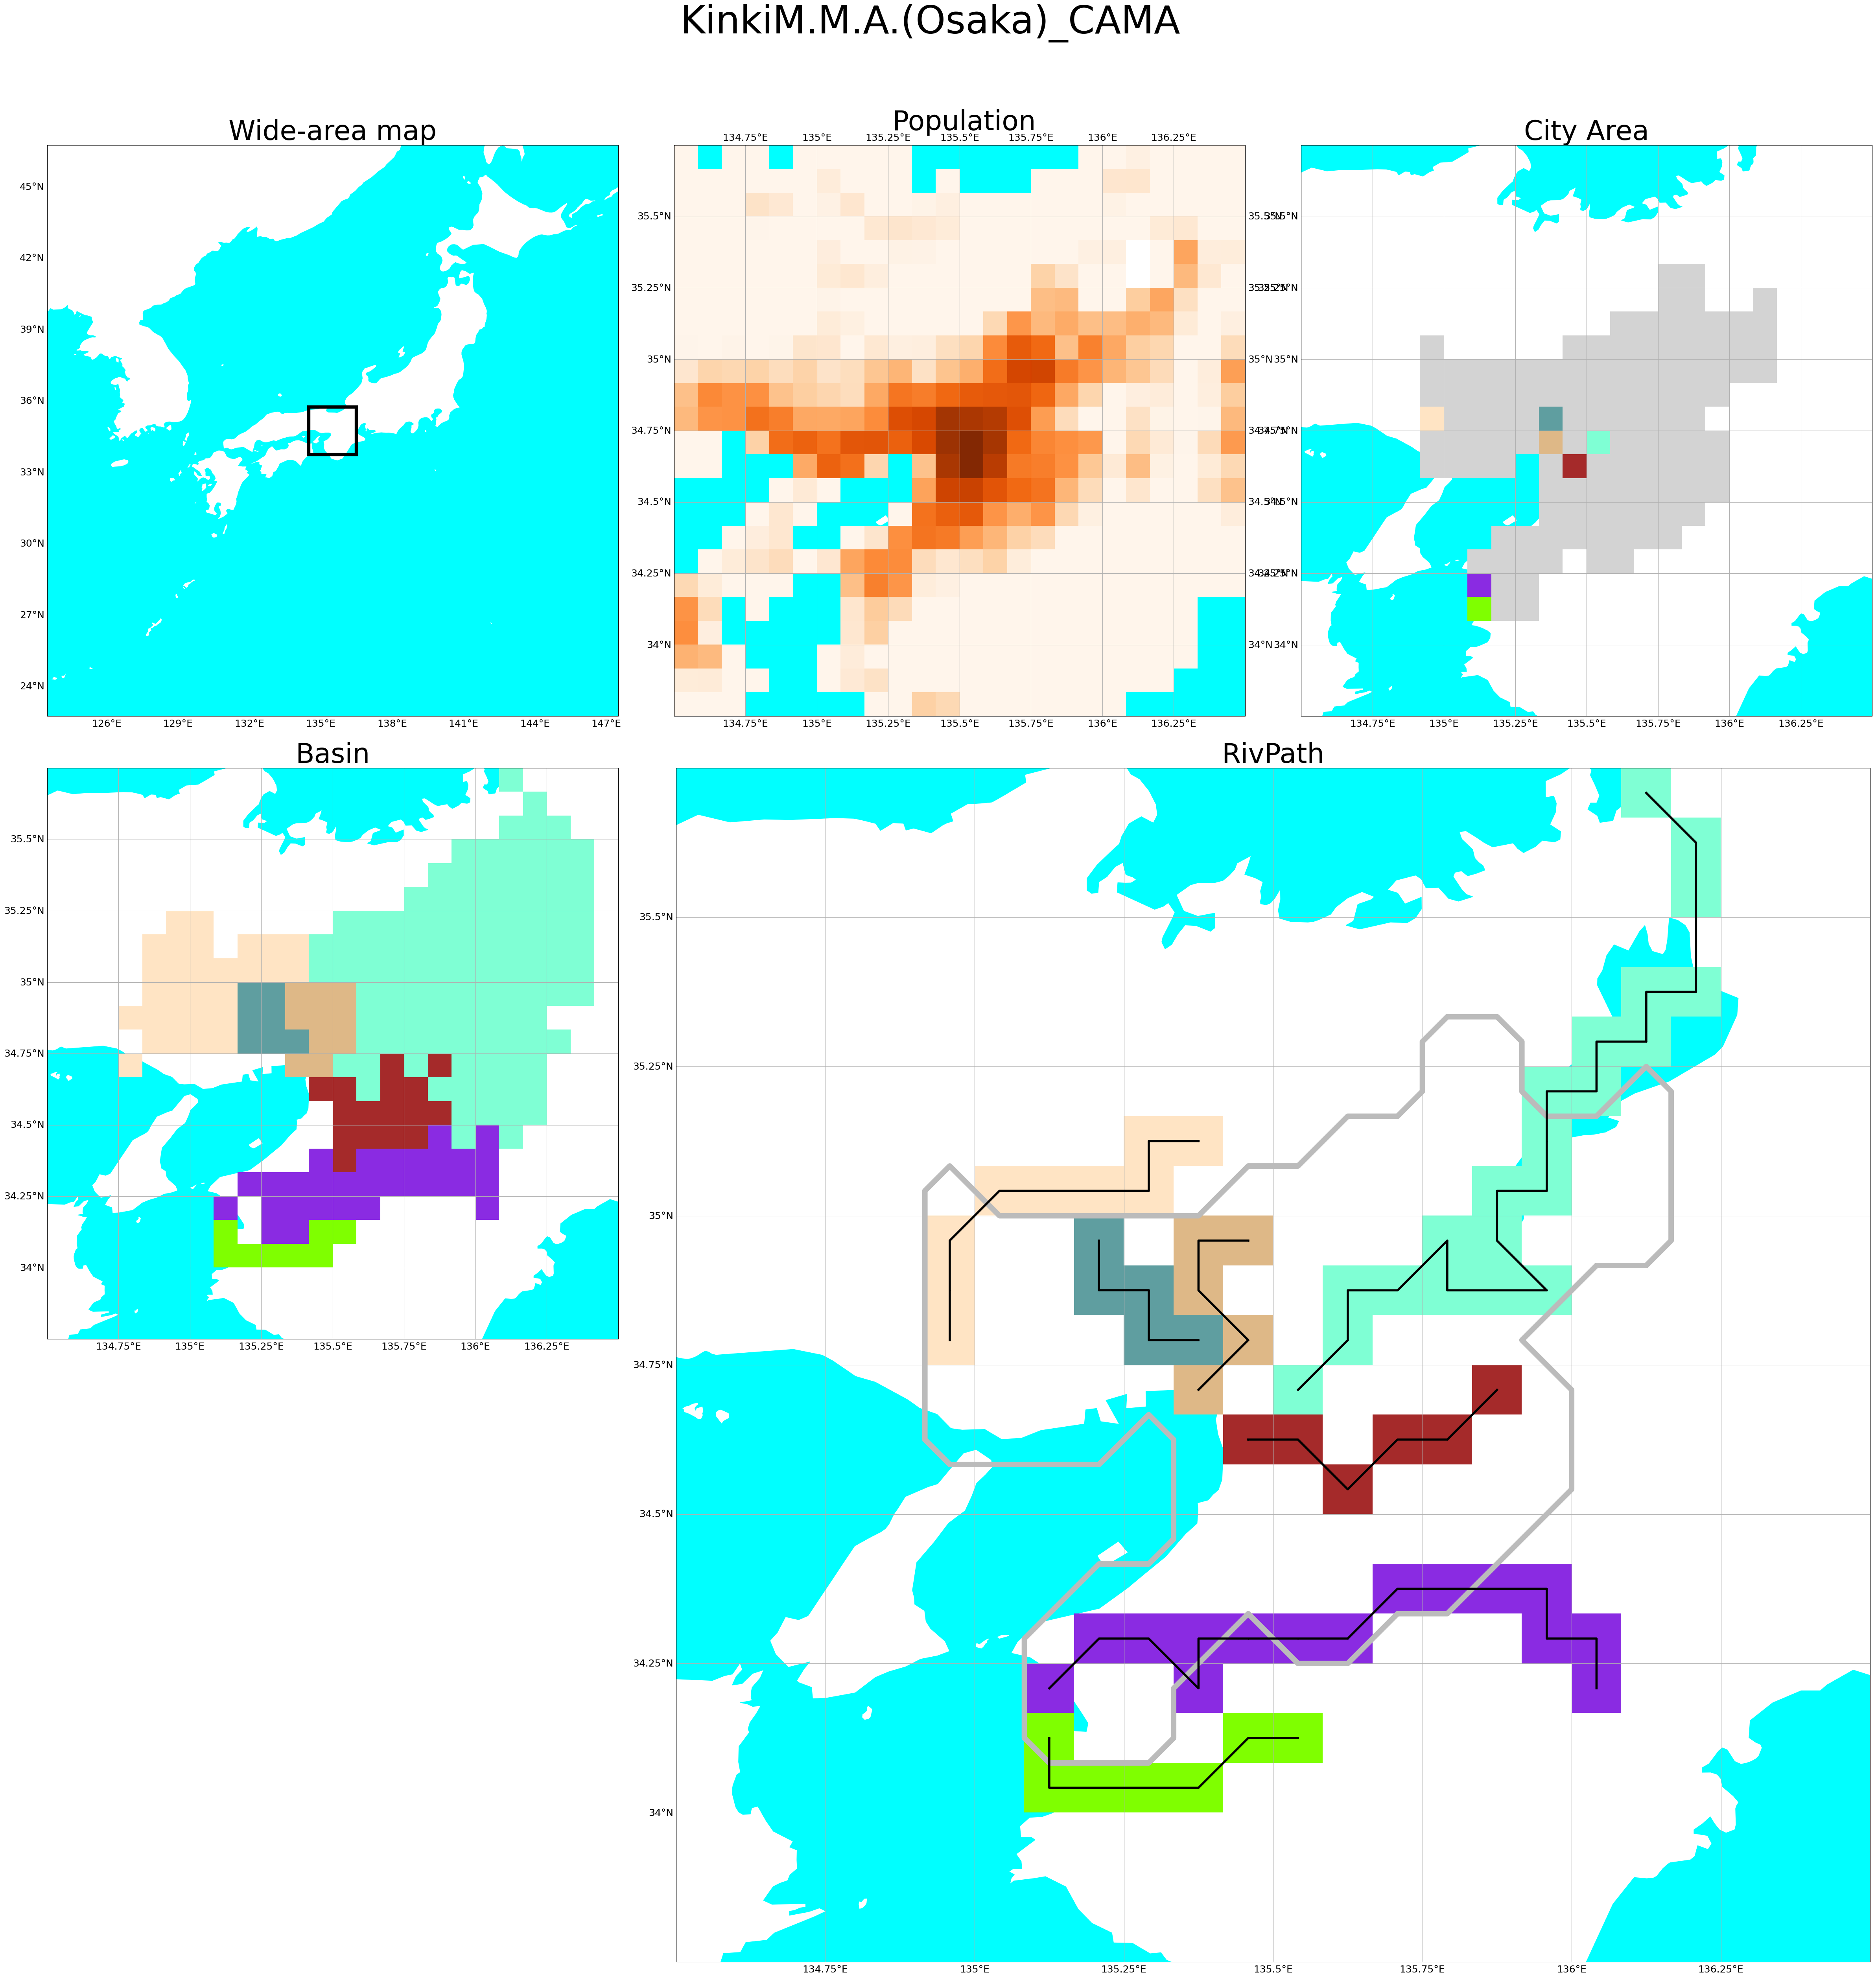

In [12]:
#---------------------------------------------------------------------------------------------------------------
# PATH
#---------------------------------------------------------------------------------------------------------------
root_dir = "/home/kajiyama/H08/H08_20230612"
# lonlat data
file_path = f"{root_dir}/map/dat/cty_lst_/city_list03.txt"
# city mask data
cmsk_path = f"{root_dir}/map/dat/cty_msk_"
elv_path = f"{root_dir}/map/dat/elevtn.CAMA.gl5"
pop_path = f"{root_dir}/map/dat/pop_tot_/C05_a___20000000.gl5" # @kajiyama
# riv data
rivnum_path = f"{root_dir}/map/out/riv_num_/rivnum.CAMA.gl5"
rivara_path = f"{root_dir}/map/out/riv_ara_/rivara.CAMA.gl5"
rivnxl_path = f"{root_dir}/map/out/riv_nxl_/rivnxl.CAMA.gl5"
# takahashi data
josui_path = f"{root_dir}/map/dat/josui_gesui_seki/20230725_jyousui.csv"
gesui_path = f"{root_dir}/map/dat/josui_gesui_seki/20230725_gesui.csv"
seki_path = f"{root_dir}/map/dat/josui_gesui_seki/20230725_seki.csv"

#---------------------------------------------------------------------------------------------------------------
# Initialization
#---------------------------------------------------------------------------------------------------------------
main_city_list_4 = ["London", "Tokyo", "Paris", "LosAngeles-LongBeach-SantaAna"]
remove_grid = 7
pop_vmin = 1e4
pop_vmax = 1e6
loop_num = 2 # number of the city
width = 1
a = 2160
b = 4320

#---------------------------------------------------------------------------------------------------------------
# Input Data
#---------------------------------------------------------------------------------------------------------------
# load takahashi data
josui = pd.read_csv(josui_path)
gesui = pd.read_csv(gesui_path)
seki = pd.read_csv(seki_path)

# city_list.txtを開いてデータを読み取る
with open(file_path, "r") as input_file:
    lines = input_file.readlines() 

# 新しいデータをcityrange_list.txtに書き込む
city_path = f"{root_dir}/map/dat/cty_lst_/cityrange_list_temp.txt"
with open(city_path, "w") as output_file:
    for line in lines:
        parts = line.split()  # 各行をスペースで分割
        col3 = float(parts[2])
        col4 = float(parts[3])
        # widthを使用して新しいデータを計算
        new_col1 = col3 - width
        new_col2 = col3 + width
        new_col3 = col4 - width
        new_col4 = col4 + width
        sotowaku_col1 = col3 - (12 * width)
        sotowaku_col2 = col3 + (12 * width)
        sotowaku_col3 = col4 - (12 * width)
        sotowaku_col4 = col4 + (12 * width)
        # 新しいデータを行に追加
        new_line = f"{line.strip()} {new_col1} {new_col2} {new_col3} {new_col4} {sotowaku_col1} {sotowaku_col2} {sotowaku_col3} {sotowaku_col4}\n"
        output_file.write(new_line)

#---------------------------------------------------------------------------------------------------------------
# Get Lon Lat 
#---------------------------------------------------------------------------------------------------------------

# open city information text
with open(city_path, 'r') as file:
    all_lines = file.readlines()

# city loop
for idx, line in enumerate(all_lines[:loop_num]):  # loop_numまでの行のみを処理
    line = line.strip()
    if not line:
        break

    parts = line.split()
    city_num = parts[0].zfill(3)
    city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
    lonmin = float(parts[6])
    lonmax = float(parts[7])
    latmin = float(parts[8])
    latmax = float(parts[9])
    sotowaku_lonmin = float(parts[10])
    sotowaku_lonmax = float(parts[11])
    sotowaku_latmin = float(parts[12])
    sotowaku_latmax = float(parts[13])

    ### Define the latitudes and longitudes
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat = np.linspace(-90, 90, a+1)
    lon = np.linspace(-180, 180, b+1)

    ### Calculate the indices corresponding to the desired latitudes and longitudes
    lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])
    sotowaku_lat_start, sotowaku_lat_end = np.searchsorted(lat, [sotowaku_latmin, sotowaku_latmax])
    sotowaku_lon_start, sotowaku_lon_end = np.searchsorted(lon, [sotowaku_lonmin, sotowaku_lonmax])
    
    # adjust to 0.25 grid (lonlat)
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1
    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1
        
    # 24 grid x 24 grid
    width_grid = width * 12 * 2
    lat_end = lat_start + width_grid
    lon_end = lon_start + width_grid
    
    # adjust to 0.25 grid (sotowaku)
    if sotowaku_lat_start%3 == 0:
        sotowaku_lat_start = sotowaku_lat_start
    elif sotowaku_lat_start%3 == 1:
        sotowaku_lat_start -= 1
    elif sotowaku_lat_start%3 == 2:
        sotowaku_lat_start += 1
    # lon
    if sotowaku_lon_start%3 == 0:
        sotowaku_lon_start = sotowaku_lon_start
    elif sotowaku_lon_start%3 == 1:
        sotowaku_lon_start -= 1
    elif sotowaku_lon_start%3 == 2:
        sotowaku_lon_start += 1

    # 12*24 grid x 12*24 grid
    sotowaku_width_grid = width * 12 * 24
    sotowaku_lat_end = sotowaku_lat_start + sotowaku_width_grid
    sotowaku_lon_end = sotowaku_lon_start + sotowaku_width_grid

    print(city)
    print("lat", sotowaku_lat_start)
    print("lat",sotowaku_lat_end)
    print("lon",sotowaku_lon_start)
    print("lon",sotowaku_lon_end, "\n")

    print("lat", lat_start)
    print("lat",lat_end)
    print("lon",lon_start)
    print("lon",lon_end, "\n")

#---------------------------------------------------------------------------------------------------------------
#  Load city mask
#---------------------------------------------------------------------------------------------------------------

    g_mask = np.fromfile(f'{cmsk_path}/city_00000{city_num}.gl5', 'float32').reshape(a, b)
    g_mask = np.flipud(g_mask)
    g_mask = np.ma.masked_where(g_mask >= 1E20, g_mask)
    g_mask_cropped = g_mask[lat_start:lat_end, lon_start:lon_end]
    g_mask_cropped = np.flipud(g_mask_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#  Load population
#---------------------------------------------------------------------------------------------------------------

    g_pop = np.fromfile(pop_path, 'float32').reshape(a, b)
    g_pop = np.flipud(g_pop)
    g_pop = np.ma.masked_where(g_pop >= 1E20, g_pop)
    g_pop_cropped = g_pop[lat_start:lat_end, lon_start:lon_end]
    g_pop_cropped = np.flipud(g_pop_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load basin data
#---------------------------------------------------------------------------------------------------------------

    g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(a, b)
    g_rivnum = np.flipud(g_rivnum)
    g_rivnum = np.ma.masked_where(g_rivnum >= 1E20, g_rivnum)
    Rivnum_A_array = g_rivnum[lat_start:lat_end, lon_start:lon_end]
    Rivnum_A_array = np.flipud(Rivnum_A_array)
    Rivnum_A_array = np.ma.masked_where(~np.isfinite(Rivnum_A_array) | (Rivnum_A_array == 0), Rivnum_A_array)

#---------------------------------------------------------------------------------------------------------------
#  Load upper river catchment area
#---------------------------------------------------------------------------------------------------------------

    g_rivara = np.fromfile(rivara_path, 'float32').reshape(a, b)
    g_rivara = np.flipud(g_rivara)
    g_rivara = np.ma.masked_where(g_rivara >= 1E20, g_rivara)
    g_rivara_cropped = g_rivara[lat_start:lat_end, lon_start:lon_end]
    g_rivara_cropped = np.flipud(g_rivara_cropped)
    g_rivara_cropped = np.ma.masked_where(~np.isfinite(g_rivara_cropped) | (g_rivara_cropped == 0), g_rivara_cropped)

#---------------------------------------------------------------------------------------------------------------
#  Load river's next l coordinate data
#---------------------------------------------------------------------------------------------------------------

    g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(a, b)
    g_rivnxl = np.flipud(g_rivnxl)
    g_rivnxl = np.ma.masked_where(g_rivnxl >= 1E20, g_rivnxl)
    g_rivnxl_cropped = g_rivnxl[lat_start:lat_end, lon_start:lon_end]
    g_rivnxl_cropped = np.flipud(g_rivnxl_cropped)
    g_rivnxl_cropped = np.ma.masked_where(~np.isfinite(g_rivnxl_cropped) | (g_rivnxl_cropped == 0), g_rivnxl_cropped)
    
#---------------------------------------------------------------------------------------------------------------
#   rivnum data only where city mask exists
#---------------------------------------------------------------------------------------------------------------

    Rivnum_A_array_city = np.where(g_mask_cropped == 1, Rivnum_A_array, np.nan)
    Rivnum_A_array_city = np.ma.masked_where(~np.isfinite(Rivnum_A_array_city) | (Rivnum_A_array_city == 0), Rivnum_A_array_city)

#---------------------------------------------------------------------------------------------------------------
# DRAW
#---------------------------------------------------------------------------------------------------------------

    # Create the plot
    fig = plt.figure(figsize=(60, 60))
    fig.suptitle(f'{city}_CAMA', fontsize=70, y=0.94)

    gs = gridspec.GridSpec(6, 6)

    # font size
    plt.rcParams['font.size'] = 18

    # convert real lonlat to h08 lonlat
    latmin_gl5 = lat[lat_start]
    latmax_gl5 = lat[lat_end]
    lonmin_gl5 = lon[lon_start]
    lonmax_gl5 = lon[lon_end]

    sotowaku_latmin_gl5 = lat[sotowaku_lat_start]
    sotowaku_latmax_gl5 = lat[sotowaku_lat_end]
    sotowaku_lonmin_gl5 = lon[sotowaku_lon_start]
    sotowaku_lonmax_gl5 = lon[sotowaku_lon_end]

    # projection
    projection = ccrs.PlateCarree()
    extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)
    extent2 = (sotowaku_lonmin_gl5, sotowaku_lonmax_gl5, sotowaku_latmin_gl5, sotowaku_latmax_gl5)
    
#---------------------------------------------------------------------------------------------------------------
# DRAW Wide-area map
#---------------------------------------------------------------------------------------------------------------

    rectangle_lon_min, rectangle_lon_max, rectangle_lat_min, rectangle_lat_max = extent

    rectangle = Rectangle((rectangle_lon_min, rectangle_lat_min),
                        rectangle_lon_max - rectangle_lon_min,
                        rectangle_lat_max - rectangle_lat_min,
                        facecolor='none',
                        edgecolor='black',
                        linewidth=6,
                        transform=ccrs.PlateCarree(), zorder=2)
    
    # add subplot(gs=6x6, ax9=2x2)
    ax9 = fig.add_subplot(gs[0:2, 0:2], projection=projection)
    ax9.set_extent(extent2, crs=projection)
    gl = ax9.gridlines(draw_labels=True)
    gl.xlines = False 
    gl.ylines = False
    gl.xlabels_top = False   
    gl.ylabels_right = False 
    
    # Add features and labels   
    ax9.add_feature(cfea.OCEAN, color='#00FFFF')
    ax9.add_patch(rectangle)
    ax9.set_title('Wide-area map', fontsize=50)
    
#---------------------------------------------------------------------------------------------------------------
#  　主要な流域を選ぶ
#---------------------------------------------------------------------------------------------------------------

    # g_ara_num_croppedを構造化配列として作成
    dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
    g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)
    
    # rivaraとrivnumのデータをg_ara_num_croppedに追加
    g_ara_num_cropped['rivara'] = g_rivara_cropped
    g_ara_num_cropped['rivnum'] = Rivnum_A_array
    
    # g_ara_num_croppedのrivnumをマスク付き配列として取得
    Rivnum_A_array_masked = np.ma.masked_array(g_ara_num_cropped['rivnum'], np.isnan(g_ara_num_cropped['rivnum']))
    
    # マスクされていない要素(Nanじゃない値)のユニークな値とその出現回数を取得
    unique_values, counts = np.unique(Rivnum_A_array_masked.compressed(), return_counts=True)
    value_counts_dict = dict(zip(unique_values, counts))
    
    # 値（個数）の多い順にソート
    # 都市マスク内の流域番号で，出現回数が多い順に並んでいるはず
    sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))
    
    # 値（個数）がremove grid以上の項目のみを持つ新しい辞書を作成
    # 流域が小さい物は削除する作業に該当
    filtered_dict_g12 = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_grid}
    
    # 空っぽのマスク配列(24x24を作る)
    Rivnum_B_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')
    
    # filtered_dict_g12のキー(流域ID)に対して繰り返し処理を行い、
    # それぞれのrivnumがRivnum_A_array_maskedに存在する位置を特定します。
    for rivnum_id in filtered_dict_g12.keys():
        # 同じrivnumの位置を取得
        matching_positions = np.where(Rivnum_A_array_masked.data == rivnum_id)
        # これらの位置に新しい配列にrivnumを設定
        Rivnum_B_array[matching_positions] = rivnum_id
        
    # 0 or 非有限数の要素をマスクする
    # Rivnum_B_arrayは都市マスクなしのすべての流域
    Rivnum_B_array = np.ma.masked_where(~np.isfinite(Rivnum_B_array) | (Rivnum_B_array == 0), Rivnum_B_array)
    
#---------------------------------------------------------------------------------------------------------------
#  Rivnum_B_array only where city mask exist
#---------------------------------------------------------------------------------------------------------------

    # Rivnum_B_arrayの値が存在しないか、値が0の場所をTrueとするマスクを作成
    invalid_mask = np.isnan(Rivnum_B_array) | (Rivnum_B_array == 0)
    # g_mask_croppedが1でない場所、または上記のマスクがTrueの場所をマスクとして指定
    cityarea_with_rivnum_b_array = np.ma.masked_where((g_mask_cropped != 1) | invalid_mask, Rivnum_B_array)
    
    # Rivnum_B_arrayで都市マスク内以外の値をnp.nanに変更
    Rivnum_B_array_citymasked = np.where(g_mask_cropped == 1, Rivnum_B_array, np.nan)
    # 欠損値 or 非有限数の要素をマスクする
    Rivnum_B_array_citymasked = np.ma.masked_where(~np.isfinite(Rivnum_B_array_citymasked) | (Rivnum_B_array_citymasked >= 1E20), Rivnum_B_array_citymasked)
    
    #二つの処理はほぼ同じであり，rivnum_B_array_citymaskedは都市マスクの外にnan値を持つ

#---------------------------------------------------------------------------------------------------------------
#  rivaraを使って河口グリッドを探索する
#---------------------------------------------------------------------------------------------------------------

    # g_ara_num_croppedを構造化配列として作成
    dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
    g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)
    
    # rivaraとrivnumのデータをg_ara_num_croppedに追加
    g_ara_num_cropped['rivara'] = g_rivara_cropped
    g_ara_num_cropped['rivnum'] = Rivnum_B_array_citymasked
    
    # マスクされていない要素のユニークな値とその出現回数を取得
    # 都市マスク内の流域グリッド数で出現回数が多い物を探索している
    unique_values, counts = np.unique(cityarea_with_rivnum_b_array.compressed(), return_counts=True)
    value_counts_dict = dict(zip(unique_values, counts))
    
    # データ型とサイズに基づいて新しい配列を作成
    rivnum_max_array = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
    
    for rivnum_id in value_counts_dict.keys():
        # 同じrivnumの位置を取得
        matching_positions = np.where(g_ara_num_cropped['rivnum'] == rivnum_id) 
        # これらの位置におけるrivaraの最大値の位置を取得
        max_rivara_position = np.argmax(g_ara_num_cropped['rivara'][matching_positions])       
        # 最大のrivaraの位置に対応するrivnumを新しい配列に保存する
        # 河口グリッドに該当
        rivnum_max_array[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id
        
#---------------------------------------------------------------------------------------------------------------
#  make riv nextl lonlat coordinate array 24x24x2
#---------------------------------------------------------------------------------------------------------------
    
    # l coordiate to lonlat coordinate
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    result = np.empty(g_rivnxl_cropped.shape, dtype=tuple)
    mask = ~np.isnan(g_rivnxl_cropped)
    result[mask] = vfunc(g_rivnxl_cropped[mask])
    result_shape = (result.shape[0], result.shape[1], 2)

    result_list = []
    for row in result:
        for x, y in row:
            # width_grid = cropped scale(24x24)
            modified_x = width_grid - (x - lat_start)
            modified_y = y - lon_start
            result_list.append((modified_x, modified_y))

    result_2424 = np.array(result_list).reshape(result_shape)
    result_2424 = result_2424.astype(int)

        
#---------------------------------------------------------------------------------------------------------------
#  河口からの
#  その中で流域面積が最大になるグリッドを探索
#---------------------------------------------------------------------------------------------------------------

    results_dict = {}
    # マスク内に存在する流域ID
    unique_ids = np.unique(rivnum_max_array.compressed())
    riv_path_array = rivnum_max_array.copy()
    visited_coords = set()

    for uid in unique_ids:
        # 河口グリッドのインデックス
        coords_a = np.argwhere(rivnum_max_array == uid)
        if coords_a.size > 0:
            target_coord = tuple(coords_a[0]) 
            path_coords = [target_coord]
            for _ in range(300):
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                # result_2424はrivnxlのlonlat表示なので，target_coordを次のセルに指し示すrivnxlのインデックスを取得
                matched_coords = np.argwhere(np.all(target_coord == result_2424, axis=2))
                if len(matched_coords) == 0:
                    break
                # マッチしたインデックスの中でrivaraが最大のものを選ぶ
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                riv_path_array[best_coord[0], best_coord[1]] = uid
                target_coord = best_coord 
                # path_coordに経路を足していく
                path_coords.append(target_coord)

            # 各流域の経路を保存
            results_dict[uid] = path_coords
            
#---------------------------------------------------------------------------------------------------------------
# 都市マスク内に存在する流域(unique_id)を全範囲(Rivnum_B_array)で取得する
#---------------------------------------------------------------------------------------------------------------

    Rivnum_masked_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')
    for uid in unique_ids:
        row_indices, col_indices = np.where(Rivnum_B_array == uid)
        Rivnum_masked_array[row_indices, col_indices] = uid


#---------------------------------------------------------------------------------------------------------------
# 流域IDと色の紐付け
#---------------------------------------------------------------------------------------------------------------

    def get_unique_non_masked_values(values):
        result = []
        for value in np.unique(values):
            if value is not np.ma.masked and not np.isnan(value):
                result.append(value)
        return result
    
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)
    
    def is_whiteish(color):
        r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
        return (r + g + b) / 3 > 230  # Check if the average is above the threshold
    
    def is_grayish(color):
        r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
        deviation = max(r, g, b) - min(r, g, b)
        return deviation <= 20
    
    def is_blueish(color):
        r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
        return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

    def get_filtered_colors(all_colors):
        result = []
        for color in all_colors:
            if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
                result.append(color)
        return result
    
    # 流域に固有の色を割り振る
    all_colors = list(CSS4_COLORS.values())
    filtered_colors = get_filtered_colors(all_colors)
    colors_list = filtered_colors[:num_colors]
    cmap = ListedColormap(colors_list) # DRAWで使用
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i
        
    def get_index(val):
        return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

    
#---------------------------------------------------------------------------------------------------------------
#  Basinの図を作図する
#---------------------------------------------------------------------------------------------------------------

    def plot_data(fig, gs_position, data, title):
        indexed_data = np.vectorize(get_index)(data)
        ax = fig.add_subplot(gs_position, projection=projection)
        ax.set_extent(extent, projection)
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = False   # Turn off top x-axis labels
        gl.ylabels_right = False # Turn off right y-axis labels
        ax.add_feature(cfea.OCEAN, color='#00FFFF')
        img = ax.imshow(indexed_data,
                        origin='upper',
                        extent=extent,
                        transform=projection,
                        cmap=cmap,
                        vmin=0, vmax=num_colors-1)
        ax.set_title(title, fontsize=50)
        return ax, img

    ax18, img18 = plot_data(fig, gs[2:4, 0:2], Rivnum_masked_array, 'Basin')

#---------------------------------------------------------------------------------------------------------------
#  City_areaを作図
#---------------------------------------------------------------------------------------------------------------

    cmap_gray = colors.ListedColormap(['none', 'lightgray'])
    bounds_gray = [0, 0.5, 1]
    norm_gray = colors.BoundaryNorm(bounds_gray, cmap_gray.N)
    
    def plot_data_mask(fig, gs_position, data, title):
        indexed_data = np.vectorize(get_index)(data)
        ax = fig.add_subplot(gs_position, projection=projection)
        ax.set_extent(extent, projection)
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = False   # Turn off top x-axis labels
        gl.ylabels_right = False # Turn off right y-axis labels
        ax.add_feature(cfea.OCEAN, color='#00FFFF')
        img = ax.imshow(indexed_data,
                        origin='upper',
                        extent=extent,
                        transform=projection,
                        cmap=cmap,
                        vmin=0, vmax=num_colors-1, zorder=2)
        img_gray = ax.imshow(g_mask_cropped, origin='upper', extent=extent, transform=projection, cmap=cmap_gray, norm=norm_gray, zorder=1)
        ax.set_title(title, fontsize=50)
        return ax, img

    ax3, img12 = plot_data_mask(fig, gs[0:2, 4:6], rivnum_max_array, 'City Area')
    
#---------------------------------------------------------------------------------------------------------------
# 人口をプロットする
#---------------------------------------------------------------------------------------------------------------

    # Add subplot for population data
    ax = fig.add_subplot(gs[0:2, 2:4], projection=projection)
    # Set extent
    ax.set_extent(extent, crs=projection)
    # set gridline
    ax.gridlines(draw_labels=True)
    # Add features and labels
    ax.add_feature(cfea.OCEAN, color='#00FFFF')
    # Plot the population data
    img = ax.imshow(g_pop_cropped,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap='Oranges',
                    norm=colors.LogNorm(vmin=pop_vmin, vmax=pop_vmax)) # Use log color scale
    # set colorbar
    #fig.colorbar(img, ax=ax, orientation='horizontal')
    # Set title
    ax.set_title(' Population', fontsize=50)
    
#---------------------------------------------------------------------------------------------------------------
# RivPathの図を描く
#---------------------------------------------------------------------------------------------------------------

    def plot_path_zorder(fig, gs_position, data, title, results_dict=None, latmin_gl5=None, latmax_gl5=None, lonmin_gl5=None, lonmax_gl5=None):
        indexed_data = np.vectorize(get_index)(data)
        ax = fig.add_subplot(gs_position, projection=projection)
        ax.set_extent(extent, projection)
        ax.scatter(josui['lon'], josui['lat'], color='red', s=200, transform=projection,zorder=3)
        ax.scatter(gesui['lon'], gesui['lat'], color='blue', s=200, transform=projection, zorder=3)
        ax.scatter(seki['lon'], seki['lat'], color='green', s=200, transform=projection, zorder=3)
        light_gray = '#BBBBBB'  # 16進数で薄いグレー
        # city maskをコンターで描く
        contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=10, origin='upper', extent=extent, transform=projection, zorder=3)


        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = False   # Turn off top x-axis labels
        gl.ylabels_right = False # Turn off right y-axis labels

        ax.add_feature(cfea.OCEAN, color='#00FFFF')
        ax.add_feature(cfea.LAKES, color='#00FFFF')
        img = ax.imshow(indexed_data,
                        origin='upper',
                        extent=extent,
                        transform=projection,
                        cmap=cmap,
                        vmin=0, vmax=num_colors-1, zorder=2)
        light_gray = '#BBBBBB'  # 16進数で薄いグレー
        # contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=10, origin='upper', extent=extent, transform=projection, zorder=3)
        ax.set_title(title, fontsize=50)

        # 新しく追加された赤い線をプロットして繋ぐ機能
        if results_dict is not None and latmin_gl5 is not None and latmax_gl5 is not None and lonmin_gl5 is not None and lonmax_gl5 is not None:
            for key, path in results_dict.items():
                lat_coords, lon_coords = zip(*path)
                lat_coords = [latmax_gl5 - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
                lon_coords = [(lon + (1/(width * 2)))*(1/12) + lonmin_gl5 for lon in lon_coords]
                ax.plot(lon_coords, lat_coords, marker='o', markersize=2, color='black', linestyle='-', linewidth=4, transform=projection, zorder=5)

        return ax, img

    ax22, img22 = plot_path_zorder(fig, gs[2:6, 2:6], riv_path_array, 'RivPath', results_dict=results_dict, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

    plt.show()

In [ ]:
# original

import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle


#---------------------------------------------------------------------------------------------------------------
# PATH
#---------------------------------------------------------------------------------------------------------------
root_dir = "/home/kajiyama/H08/H08_20230612"
# lonlat data
file_path = f"{root_dir}/data/city_list03.txt" # @kajiyama
# city mask data
cmsk_path = f"{root_dir}/cty_msk_" # @kajiyama
elv_path = f"{root_dir}/data/elevtn2.gl5" # @kajiyama
pop_path = f"{root_dir}/data/C05_a___20000000.gl5" # @kajiyama
# riv data
rivnum_path = f"{root_dir}/rivdata/rivnum.CAMA.gl5"
rivara_path = f"{root_dir}/rivdata/rivara.CAMA.gl5"
rivnxl_path = f"{root_dir}/rivdata/rivnxl.CAMA.gl5"
# takahashi data
josui_path = f"{root_dir}/20230725_jyousui.csv"
gesui_path = f"{root_dir}/20230725_gesui.csv"
seki_path = f"{root_dir}/20230725_seki.csv"
# このpythonファイルのファイル名から図の出力ディレクトリ名を決める
current_file_name = os.path.basename(__file__)
dir_name_from_file = os.path.splitext(current_file_name)[0]
# output_dir
output_dir = os.path.join(root_dir, dir_name_from_file, )

josui = pd.read_csv(josui_path)
gesui = pd.read_csv(gesui_path)
seki = pd.read_csv(seki_path)

#output_dir = "cartopytest6/" # @kakiuchi
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

main_city_list_5 = ["London", "Tokyo", "Paris", "LosAngeles-LongBeach-SantaAna"]
main_city_list_10 = ["Chennai(Madras)","KrungThep(Bangkok)","London", "Tokyo", "Paris", "LosAngeles-LongBeach-SantaAna", "Manila", "Dhaka", "Capetown", "RiodeJaneiro" ]

remove_grid = 7

pop_vmin = 1e4
pop_vmax = 1e6

# city_list.txtを開いてデータを読み取る
with open("./data/city_list03.txt", "r") as input_file:
    lines = input_file.readlines() 


for i in range(1,2):

    main_output_dir_5 = f"{output_dir}/CAMA/dir{i}/main_5_rivdata"
    main_output_dir_21 = f"{output_dir}/CAMA/dir{i}/main_21_rivdata"
    main_output_dir_10 = f"{output_dir}/CAMA/dir{i}/main_10_rivdata"
    all_output_dir_69 = f"{output_dir}/CAMA/dir{i}/all_69_rivdata"

    #output_dir = "cartopytest6/" # @kakiuchi
    if not os.path.exists(main_output_dir_5):
        os.makedirs(main_output_dir_5)
    if not os.path.exists(main_output_dir_21):
        os.makedirs(main_output_dir_21)
    if not os.path.exists(all_output_dir_69):
        os.makedirs(all_output_dir_69)
    if not os.path.exists(main_output_dir_10):
        os.makedirs(main_output_dir_10)

    # width(図の領域)の設定
    width = i

    # 新しいデータをcityrange_list.txtに書き込む
    with open("./data/cityrange_list.txt", "w") as output_file:
        for line in lines:
            parts = line.split()  # 各行をスペースで分割
            col3 = float(parts[2])
            col4 = float(parts[3])
            # widthを使用して新しいデータを計算
            new_col1 = col3 - width
            new_col2 = col3 + width
            new_col3 = col4 - width
            new_col4 = col4 + width
            sotowaku_col1 = col3 - (12 * width)
            sotowaku_col2 = col3 + (12 * width)
            sotowaku_col3 = col4 - (12 * width)
            sotowaku_col4 = col4 + (12 * width)
            # 新しいデータを行に追加
            new_line = f"{line.strip()} {new_col1} {new_col2} {new_col3} {new_col4} {sotowaku_col1} {sotowaku_col2} {sotowaku_col3} {sotowaku_col4}\n"
            output_file.write(new_line)

    city_path = f"{root_dir}/data/cityrange_list.txt"

#---------------------------------------------------------------------------------------------------------------
    # JOB
#---------------------------------------------------------------------------------------------------------------

    loop_num = 120 # @kajiyama

    with open(city_path, 'r') as file:
        all_lines = file.readlines()


    # open city information text

    for idx, line in enumerate(all_lines[:loop_num]):  # loop_numまでの行のみを処理
        line = line.strip()
        if not line:
            break

        parts = line.split()
        city_num = parts[0].zfill(3)
        city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
        lonmin = float(parts[6])
        lonmax = float(parts[7])
        latmin = float(parts[8])
        latmax = float(parts[9])
        sotowaku_lonmin = float(parts[10])
        sotowaku_lonmax = float(parts[11])
        sotowaku_latmin = float(parts[12])
        sotowaku_latmax = float(parts[13])

        # Dimension of the data
        a = 2160
        b = 4320

        ### Define the latitudes and longitudes
        # West from UK is negative 0 <= lon <= -180
        # East from UK is positive 0 <= lon <= 180
        # small value to larger value (34-36, 138-140)
        lat = np.linspace(-90, 90, a+1)
        lon = np.linspace(-180, 180, b+1)

        ### Calculate the indices corresponding to the desired latitudes and longitudes
        lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
        lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])
        sotowaku_lat_start, sotowaku_lat_end = np.searchsorted(lat, [sotowaku_latmin, sotowaku_latmax])
        sotowaku_lon_start, sotowaku_lon_end = np.searchsorted(lon, [sotowaku_lonmin, sotowaku_lonmax])
        # adjust to 0.25 grid
        if lat_start%3 == 0:
            lat_start = lat_start
        elif lat_start%3 == 1:
            lat_start -= 1
        elif lat_start%3 == 2:
            lat_start += 1
        # lon
        if lon_start%3 == 0:
            lon_start = lon_start
        elif lon_start%3 == 1:
            lon_start -= 1
        elif lon_start%3 == 2:
            lon_start += 1
        # 24 grid x 24 grid
        width_grid = width * 12 * 2
        lat_end = lat_start + width_grid
        lon_end = lon_start + width_grid
#---------------------------------------------------------------------------------------------------------------
        if sotowaku_lat_start%3 == 0:
            sotowaku_lat_start = sotowaku_lat_start
        elif sotowaku_lat_start%3 == 1:
            sotowaku_lat_start -= 1
        elif sotowaku_lat_start%3 == 2:
            sotowaku_lat_start += 1
        # lon
        if sotowaku_lon_start%3 == 0:
            sotowaku_lon_start = sotowaku_lon_start
        elif sotowaku_lon_start%3 == 1:
            sotowaku_lon_start -= 1
        elif sotowaku_lon_start%3 == 2:
            sotowaku_lon_start += 1
        
        sotowaku_width_grid = width * 12 * 24
        sotowaku_lat_end = sotowaku_lat_start + sotowaku_width_grid
        sotowaku_lon_end = sotowaku_lon_start + sotowaku_width_grid


        def l_coordinate_to_tuple(lcoordinate):
            lat_l = a - ((lcoordinate - 1) // b)
            lon_l = (lcoordinate) % b - 1
            return (lat_l, lon_l)
        
        print(city)
        print("lat", sotowaku_lat_start)
        print("lat",sotowaku_lat_end)
        print("lon",sotowaku_lon_start)
        print("lon",sotowaku_lon_end, "\n")

        print("lat", lat_start)
        print("lat",lat_end)
        print("lon",lon_start)
        print("lon",lon_end, "\n")
        
#---------------------------------------------------------------------------------------------------------------

        g_mask = np.fromfile(f'{cmsk_path}/city_00000{city_num}.gl5', 'float32').reshape(a, b)
        g_mask = np.flipud(g_mask)
        g_mask = np.ma.masked_where(g_mask >= 1E20, g_mask)
        g_mask_cropped = g_mask[lat_start:lat_end, lon_start:lon_end]
        g_mask_cropped = np.flipud(g_mask_cropped)
#---------------------------------------------------------------------------------------------------------------

        g_pop = np.fromfile(pop_path, 'float32').reshape(a, b)
        g_pop = np.flipud(g_pop)
        g_pop = np.ma.masked_where(g_pop >= 1E20, g_pop)
        g_pop_cropped = g_pop[lat_start:lat_end, lon_start:lon_end]
        g_pop_cropped = np.flipud(g_pop_cropped)

#---------------------------------------------------------------------------------------------------------------

        g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(a, b)
        g_rivnum = np.flipud(g_rivnum)
        g_rivnum = np.ma.masked_where(g_rivnum >= 1E20, g_rivnum)
        Rivnum_A_array = g_rivnum[lat_start:lat_end, lon_start:lon_end]
        Rivnum_A_array = np.flipud(Rivnum_A_array)
        Rivnum_A_array = np.ma.masked_where(~np.isfinite(Rivnum_A_array) | (Rivnum_A_array == 0), Rivnum_A_array)

#---------------------------------------------------------------------------------------------------------------

        g_rivara = np.fromfile(rivara_path, 'float32').reshape(a, b)
        g_rivara = np.flipud(g_rivara)
        g_rivara = np.ma.masked_where(g_rivara >= 1E20, g_rivara)
        g_rivara_cropped = g_rivara[lat_start:lat_end, lon_start:lon_end]
        g_rivara_cropped = np.flipud(g_rivara_cropped)
        g_rivara_cropped = np.ma.masked_where(~np.isfinite(g_rivara_cropped) | (g_rivara_cropped == 0), g_rivara_cropped)

#---------------------------------------------------------------------------------------------------------------

        g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(a, b)
        g_rivnxl = np.flipud(g_rivnxl)
        g_rivnxl = np.ma.masked_where(g_rivnxl >= 1E20, g_rivnxl)
        g_rivnxl_cropped = g_rivnxl[lat_start:lat_end, lon_start:lon_end]
        g_rivnxl_cropped = np.flipud(g_rivnxl_cropped)
        g_rivnxl_cropped = np.ma.masked_where(~np.isfinite(g_rivnxl_cropped) | (g_rivnxl_cropped == 0), g_rivnxl_cropped)
        vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
        result = np.empty(g_rivnxl_cropped.shape, dtype=tuple)
        mask = ~np.isnan(g_rivnxl_cropped)
        result[mask] = vfunc(g_rivnxl_cropped[mask])
        result_shape = (result.shape[0], result.shape[1], 2)

        result_list = []
        for row in result:
            for x, y in row:
                modified_x = width_grid - (x - lat_start)
                modified_y = y - lon_start
                result_list.append((modified_x, modified_y))

        result_2424 = np.array(result_list).reshape(result_shape)
        result_2424 = result_2424.astype(int)
        
#---------------------------------------------------------------------------------------------------------------

        # rivnum data only where city mask exists
        Rivnum_A_array_city = np.where(g_mask_cropped == 1, Rivnum_A_array, np.nan)
        Rivnum_A_array_city = np.ma.masked_where(~np.isfinite(Rivnum_A_array_city) | (Rivnum_A_array_city == 0), Rivnum_A_array_city)

#---------------------------------------------------------------------------------------------------------------
    # DRAW
#---------------------------------------------------------------------------------------------------------------

        # Create the plot
        fig = plt.figure(figsize=(60, 60))
        fig.suptitle(f'{city}_CAMA', fontsize=70, y=0.94)
        
        gs = gridspec.GridSpec(6, 6)

        # font size
        plt.rcParams['font.size'] = 18

        # convert real lonlat to h08 lonlat
        latmin_gl5 = lat[lat_start]
        latmax_gl5 = lat[lat_end]
        lonmin_gl5 = lon[lon_start]
        lonmax_gl5 = lon[lon_end]

        sotowaku_latmin_gl5 = lat[sotowaku_lat_start]
        sotowaku_latmax_gl5 = lat[sotowaku_lat_end]
        sotowaku_lonmin_gl5 = lon[sotowaku_lon_start]
        sotowaku_lonmax_gl5 = lon[sotowaku_lon_end]

        # projection
        projection = ccrs.PlateCarree()
        extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)
        extent2 = (sotowaku_lonmin_gl5, sotowaku_lonmax_gl5, sotowaku_latmin_gl5, sotowaku_latmax_gl5)
#---------------------------------------------------------------------------------------------------------------
        # Add subplot for a data
        rectangle_lon_min, rectangle_lon_max, rectangle_lat_min, rectangle_lat_max = extent

        rectangle = Rectangle((rectangle_lon_min, rectangle_lat_min),
                            rectangle_lon_max - rectangle_lon_min,
                            rectangle_lat_max - rectangle_lat_min,
                            facecolor='none',
                            edgecolor='black',
                            linewidth=6,
                            transform=ccrs.PlateCarree(), zorder=2)
        ax9 = fig.add_subplot(gs[0:2, 0:2], projection=projection)
        # Set extent
        ax9.set_extent(extent2, crs=projection)
        # set gridline
        gl = ax9.gridlines(draw_labels=True)
        gl.xlines = False 
        gl.ylines = False
        gl.xlabels_top = False   
        gl.ylabels_right = False 
        # Add features and labels   
        ax9.add_feature(cfea.OCEAN, color='#00FFFF')
        ax9.add_patch(rectangle)
        ax9.set_title('Wide-area map', fontsize=50)
#---------------------------------------------------------------------------------------------------------------

        # g_ara_num_croppedを構造化配列として作成
        dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
        g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)
        # rivaraとrivnumのデータをg_ara_num_croppedに追加
        g_ara_num_cropped['rivara'] = g_rivara_cropped
        g_ara_num_cropped['rivnum'] = Rivnum_A_array
        # g_ara_num_croppedのrivnumをマスク付き配列として取得
        Rivnum_A_array_masked = np.ma.masked_array(g_ara_num_cropped['rivnum'], np.isnan(g_ara_num_cropped['rivnum']))
        # マスクされていない要素のユニークな値とその出現回数を取得
        unique_values, counts = np.unique(Rivnum_A_array_masked.compressed(), return_counts=True)
        value_counts_dict = dict(zip(unique_values, counts))
        # 値（個数）の多い順にソート
        sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))
        # 値（個数）が3以上の項目のみを持つ新しい辞書を作成
        filtered_dict_g12 = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_grid}
        # データ型とサイズに基づいて新しい配列を    作成
        rivnum_max_array = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
        # まず、新しいマスク付き配列を作成します。
        # 初期状態ではすべての要素がマスクされています。
        Rivnum_B_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')
        # filtered_dict_g12のキーに対して繰り返し処理を行い、
        # それぞれのrivnumがRivnum_A_array_maskedに存在する位置を特定します。
        for rivnum_id in filtered_dict_g12.keys():
            # 同じrivnumの位置を取得
            matching_positions = np.where(Rivnum_A_array_masked.data == rivnum_id)
            # これらの位置に新しい配列にrivnumを設定
            Rivnum_B_array[matching_positions] = rivnum_id
        Rivnum_B_array = np.ma.masked_where(~np.isfinite(Rivnum_B_array) | (Rivnum_B_array == 0), Rivnum_B_array)
#---------------------------------------------------------------------------------------------------------------

    # Rivnum_B_array only where city mask exist
        # Rivnum_B_arrayの値が存在しないか、値が0の場所をTrueとするマスクを作成
        invalid_mask = np.isnan(Rivnum_B_array) | (Rivnum_B_array == 0)
        # g_mask_croppedが1でない場所、または上記のマスクがTrueの場所をマスクとして指定
        cityarea_with_rivnum_b_array = np.ma.masked_where((g_mask_cropped != 1) | invalid_mask, Rivnum_B_array)
#---------------------------------------------------------------------------------------------------------------

        Rivnum_B_array_citymasked = np.where(g_mask_cropped == 1, Rivnum_B_array, np.nan)
        Rivnum_B_array_citymasked = np.ma.masked_where(~np.isfinite(Rivnum_B_array_citymasked) | (Rivnum_B_array_citymasked >= 1E20), Rivnum_B_array_citymasked)

#---------------------------------------------------------------------------------------------------------------

    # g_ara_num_croppedを構造化配列として作成
        dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
        g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)
        # rivaraとrivnumのデータをg_ara_num_croppedに追加
        g_ara_num_cropped['rivara'] = g_rivara_cropped
        g_ara_num_cropped['rivnum'] = Rivnum_B_array_citymasked
        # マスクされていない要素のユニークな値とその出現回数を取得
        unique_values, counts = np.unique(cityarea_with_rivnum_b_array.compressed(), return_counts=True)
        value_counts_dict = dict(zip(unique_values, counts))
        # print(unique_values)
        # print(counts)
        # データ型とサイズに基づいて新しい配列を作成
        rivnum_max_array = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
        # 初期状態ではすべての要素がマスクされています。
        for rivnum_id in value_counts_dict.keys():
            # print(rivnum_id)
            # 同じrivnumの位置を取得
            matching_positions = np.where(g_ara_num_cropped['rivnum'] == rivnum_id) 
            # 下のprint文
            # print(f"rivnum_id {rivnum_id} has {len(matching_positions[0])} matching positions.")
            # これらの位置におけるrivaraの最大値の位置を取得
            max_rivara_position = np.argmax(g_ara_num_cropped['rivara'][matching_positions])       
            # 最大のrivaraの位置に対応するrivnumを新しい配列に保存する
            rivnum_max_array[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id
#---------------------------------------------------------------------------------------------------------------


        results_dict = {}
        unique_ids = np.unique(rivnum_max_array.compressed())
        print(unique_ids)
        riv_path_array = rivnum_max_array.copy()
        visited_coords = set()

        for uid in unique_ids:
            coords_a = np.argwhere(rivnum_max_array == uid)
            if coords_a.size > 0:
                target_coord = tuple(coords_a[0]) 
                path_coords = [target_coord]
                for _ in range(300):
                    if target_coord in visited_coords:
                        break
                    visited_coords.add(target_coord)
                    matched_coords = np.argwhere(np.all(target_coord == result_2424, axis=2))
                    if len(matched_coords) == 0:
                        break
                    unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                    if not unvisited_matched:
                        break
                    rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                    max_index = np.argmax(rivara_values)
                    best_coord = unvisited_matched[max_index]
                    # print(best_coord[0], best_coord[1])
                    riv_path_array[best_coord[0], best_coord[1]] = uid
                    target_coord = best_coord 
                    path_coords.append(target_coord)
                
                results_dict[uid] = path_coords
#---------------------------------------------------------------------------------------------------------------
        Rivnum_masked_array = np.ma.masked_all(Rivnum_A_array_masked.shape, dtype='float32')
        for uid in unique_ids:
            row_indices, col_indices = np.where(Rivnum_B_array == uid)
            Rivnum_masked_array[row_indices, col_indices] = uid


#---------------------------------------------------------------------------------------------------------------
    # 流域IDと色の紐付け
#---------------------------------------------------------------------------------------------------------------

        def get_unique_non_masked_values(values):
            result = []
            for value in np.unique(values):
                if value is not np.ma.masked and not np.isnan(value):
                    result.append(value)
            return result
        unique_values = get_unique_non_masked_values(Rivnum_masked_array)
        num_colors = len(unique_values)
        def is_whiteish(color):
            r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
            return (r + g + b) / 3 > 230  # Check if the average is above the threshold
        def is_grayish(color):
            r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
            deviation = max(r, g, b) - min(r, g, b)
            return deviation <= 20
        def is_blueish(color):
            r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
            return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

        def get_filtered_colors(all_colors):
            result = []
            for color in all_colors:
                if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
                    result.append(color)
            return result
        all_colors = list(CSS4_COLORS.values())
        filtered_colors = get_filtered_colors(all_colors)
        colors_list = filtered_colors[:num_colors]
        cmap = ListedColormap(colors_list) # DRAWで使用
        index_dict = {}
        for i, value in enumerate(unique_values):
            index_dict[value] = i
        def get_index(val):
            return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

    # DRAW
        def plot_data(fig, gs_position, data, title):
            indexed_data = np.vectorize(get_index)(data)
            ax = fig.add_subplot(gs_position, projection=projection)
            ax.set_extent(extent, projection)
            gl = ax.gridlines(draw_labels=True)
            gl.xlabels_top = False   # Turn off top x-axis labels
            gl.ylabels_right = False # Turn off right y-axis labels
            ax.add_feature(cfea.OCEAN, color='#00FFFF')
            img = ax.imshow(indexed_data,
                            origin='upper',
                            extent=extent,
                            transform=projection,
                            cmap=cmap,
                            vmin=0, vmax=num_colors-1)
            ax.set_title(title, fontsize=50)
            return ax, img

        ax18, img18 = plot_data(fig, gs[2:4, 0:2], Rivnum_masked_array, 'Basin')
        
#---------------------------------------------------------------------------------------------------------------
    # DRAW
        cmap_gray = colors.ListedColormap(['none', 'lightgray'])
        bounds_gray = [0, 0.5, 1]
        norm_gray = colors.BoundaryNorm(bounds_gray, cmap_gray.N)
        def plot_data_mask(fig, gs_position, data, title):
            indexed_data = np.vectorize(get_index)(data)
            ax = fig.add_subplot(gs_position, projection=projection)
            ax.set_extent(extent, projection)
            gl = ax.gridlines(draw_labels=True)
            gl.xlabels_top = False   # Turn off top x-axis labels
            gl.ylabels_right = False # Turn off right y-axis labels
            ax.add_feature(cfea.OCEAN, color='#00FFFF')
            img = ax.imshow(indexed_data,
                            origin='upper',
                            extent=extent,
                            transform=projection,
                            cmap=cmap,
                            vmin=0, vmax=num_colors-1, zorder=2)
            img_gray = ax.imshow(g_mask_cropped, origin='upper', extent=extent, transform=projection, cmap=cmap_gray, norm=norm_gray, zorder=1)
            ax.set_title(title, fontsize=50)
            return ax, img

        ax3, img12 = plot_data_mask(fig, gs[0:2, 4:6], rivnum_max_array, 'City Area')
#---------------------------------------------------------------------------------------------------------------

        # Add subplot for population data
        ax = fig.add_subplot(gs[0:2, 2:4], projection=projection)
        # Set extent
        ax.set_extent(extent, crs=projection)
        # set gridline
        ax.gridlines(draw_labels=True)
        # Add features and labels
        ax.add_feature(cfea.OCEAN, color='#00FFFF')
        # Plot the population data
        img = ax.imshow(g_pop_cropped,
                        origin='upper',
                        extent=extent,
                        transform=projection,
                        cmap='Oranges',
                        norm=colors.LogNorm(vmin=pop_vmin, vmax=pop_vmax)) # Use log color scale
        # set colorbar
        fig.colorbar(img, ax=ax, orientation='horizontal')
        # Set title
        ax.set_title(' Population', fontsize=50)
#---------------------------------------------------------------------------------------------------------------

        cmap_gray = colors.ListedColormap(['none', 'lightgray'])
        bounds_gray = [0, 0.5, 1]
        norm_gray = colors.BoundaryNorm(bounds_gray, cmap_gray.N)

#---------------------------------------------------------------------------------------------------------------

        def plot_path_zorder(fig, gs_position, data, title, results_dict=None, latmin_gl5=None, latmax_gl5=None, lonmin_gl5=None, lonmax_gl5=None):
            indexed_data = np.vectorize(get_index)(data)
            ax = fig.add_subplot(gs_position, projection=projection)
            ax.set_extent(extent, projection)
            ax.scatter(josui['lon'], josui['lat'], color='red', s=200, transform=projection,zorder=3)
            ax.scatter(gesui['lon'], gesui['lat'], color='blue', s=200, transform=projection, zorder=3)
            ax.scatter(seki['lon'], seki['lat'], color='green', s=200, transform=projection, zorder=3)
            light_gray = '#BBBBBB'  # 16進数で薄いグレー
            contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=10, origin='upper', extent=extent, transform=projection, zorder=3)

            
            gl = ax.gridlines(draw_labels=True)
            gl.xlabels_top = False   # Turn off top x-axis labels
            gl.ylabels_right = False # Turn off right y-axis labels
            
            ax.add_feature(cfea.OCEAN, color='#00FFFF')
            ax.add_feature(cfea.LAKES, color='#00FFFF')
            img = ax.imshow(indexed_data,
                            origin='upper',
                            extent=extent,
                            transform=projection,
                            cmap=cmap,
                            vmin=0, vmax=num_colors-1, zorder=2)
            light_gray = '#BBBBBB'  # 16進数で薄いグレー
            # contour = ax.contour(g_mask_cropped, levels=[0.5], colors=light_gray, linewidths=10, origin='upper', extent=extent, transform=projection, zorder=3)
            ax.set_title(title, fontsize=50)

            # 新しく追加された赤い線をプロットして繋ぐ機能
            if results_dict is not None and latmin_gl5 is not None and latmax_gl5 is not None and lonmin_gl5 is not None and lonmax_gl5 is not None:
                for key, path in results_dict.items():
                    lat_coords, lon_coords = zip(*path)
                    lat_coords = [latmax_gl5 - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
                    lon_coords = [(lon + (1/(width * 2)))*(1/12) + lonmin_gl5 for lon in lon_coords]
                    ax.plot(lon_coords, lat_coords, marker='o', markersize=2, color='black', linestyle='-', linewidth=4, transform=projection, zorder=5)

            return ax, img

        ax22, img22 = plot_path_zorder(fig, gs[2:6, 2:6], riv_path_array, 'RivPath', results_dict=results_dict, latmin_gl5=latmin_gl5, latmax_gl5=latmax_gl5, lonmin_gl5=lonmin_gl5, lonmax_gl5=lonmax_gl5)

#---------------------------------------------------------------------------------------------------------------

    # Save the figure
        if city in main_city_list_5:
            fig_name = os.path.join(main_output_dir_5, f'{city}_CAMA_map.png')
            fig.savefig(fig_name)
            plt.close(fig)


        if city in main_city_list_10:
            fig_name = os.path.join(main_output_dir_10, f'{city}_CAMA_map.png')
            fig.savefig(fig_name)
            plt.close(fig) 

        fig_name = os.path.join(all_output_dir_69, f'{city}_CAMA_map.png')
        fig.savefig(fig_name)
        plt.close(fig)